In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

import pandas as pd

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [2]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2022-01-26 04:40:49--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.2’

postgresql-42.2.9.j 100%[===================>] 892.61K  5.36MB/s    in 0.2s    

2022-01-26 04:40:49 (5.36 MB/s) - ‘postgresql-42.2.9.jar.2’ saved [914037/914037]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NewsPopularity").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://onlinenews-1.s3.us-west-1.amazonaws.com/OnlineNewsPopularity_clean.csv"
spark.sparkContext.addFile(url)
news_df = spark.read.csv(SparkFiles.get("OnlineNewsPopularity_clean.csv"), sep=",", header=True, inferSchema=True)

In [5]:
news_df.show()

+--------------------+---------+--------------+----------------+---------------+----------------+------------------------+---------+--------------+--------+----------+--------------------+------------+-------------------------+-----------------------------+-------------------+----------------------+--------------------+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------------------+-------------------------+--------------------------+-----------------+------------------+--------------------+-------------------+-----------------+-------------------+-----------------+----------+-----------+-----------+-----------+-----------+-----------+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+----------------------+----------------------+---------------------+----------------------+---------------------

In [6]:
time_df = news_df.select(["url","weekday_is_monday","weekday_is_tuesday","weekday_is_wednesday", "weekday_is_thursday","weekday_is_friday", "weekday_is_saturday", "weekday_is_sunday","is_weekend"])
time_df.show()

+--------------------+-----------------+------------------+--------------------+-------------------+-----------------+-------------------+-----------------+----------+
|                 url|weekday_is_monday|weekday_is_tuesday|weekday_is_wednesday|weekday_is_thursday|weekday_is_friday|weekday_is_saturday|weekday_is_sunday|is_weekend|
+--------------------+-----------------+------------------+--------------------+-------------------+-----------------+-------------------+-----------------+----------+
|http://mashable.c...|                1|                 0|                   0|                  0|                0|                  0|                0|         0|
|http://mashable.c...|                1|                 0|                   0|                  0|                0|                  0|                0|         0|
|http://mashable.c...|                1|                 0|                   0|                  0|                0|                  0|                0|    

In [7]:
shares_df = news_df.select(["url", "shares"])
shares_df.show()

+--------------------+------+
|                 url|shares|
+--------------------+------+
|http://mashable.c...|   593|
|http://mashable.c...|   711|
|http://mashable.c...|  1500|
|http://mashable.c...|  1200|
|http://mashable.c...|   505|
|http://mashable.c...|   855|
|http://mashable.c...|   556|
|http://mashable.c...|   891|
|http://mashable.c...|  3600|
|http://mashable.c...|   710|
|http://mashable.c...|  2200|
|http://mashable.c...|  1900|
|http://mashable.c...|   823|
|http://mashable.c...| 10000|
|http://mashable.c...|   761|
|http://mashable.c...|  1600|
|http://mashable.c...| 13600|
|http://mashable.c...|  3100|
|http://mashable.c...|  5700|
|http://mashable.c...| 17100|
+--------------------+------+
only showing top 20 rows



In [8]:
category_df = news_df.select(["url", "data_channel_is_lifestyle", "data_channel_is_entertainment", "data_channel_is_bus", "data_channel_is_socmed", "data_channel_is_tech", "data_channel_is_world"])
category_df.show()

+--------------------+-------------------------+-----------------------------+-------------------+----------------------+--------------------+---------------------+
|                 url|data_channel_is_lifestyle|data_channel_is_entertainment|data_channel_is_bus|data_channel_is_socmed|data_channel_is_tech|data_channel_is_world|
+--------------------+-------------------------+-----------------------------+-------------------+----------------------+--------------------+---------------------+
|http://mashable.c...|                        0|                            1|                  0|                     0|                   0|                    0|
|http://mashable.c...|                        0|                            0|                  1|                     0|                   0|                    0|
|http://mashable.c...|                        0|                            0|                  1|                     0|                   0|                    0|
|http://ma

In [9]:
words_df = news_df.select(["url", "n_tokens_content", "n_tokens_title", "n_unique_tokens", "n_non_stop_words", "n_non_stop_unique_tokens", "average_token_length"])
words_df.show()

+--------------------+----------------+--------------+---------------+----------------+------------------------+--------------------+
|                 url|n_tokens_content|n_tokens_title|n_unique_tokens|n_non_stop_words|n_non_stop_unique_tokens|average_token_length|
+--------------------+----------------+--------------+---------------+----------------+------------------------+--------------------+
|http://mashable.c...|             219|            12|    0.663594467|     0.999999992|             0.815384609|         4.680365297|
|http://mashable.c...|             255|             9|    0.604743081|     0.999999993|             0.791946303|          4.91372549|
|http://mashable.c...|             211|             9|    0.575129531|     0.999999992|             0.663865541|         4.393364929|
|http://mashable.c...|             531|             9|    0.503787878|     0.999999997|             0.665634673|         4.404896422|
|http://mashable.c...|            1072|            13|    0.41

In [10]:
processing_df = news_df.select(["url", "LDA_00", "LDA_01", "LDA_02", "LDA_03", "LDA_04"])
processing_df.show()

+--------------------+-----------+-----------+-----------+-----------+-----------+
|                 url|     LDA_00|     LDA_01|     LDA_02|     LDA_03|     LDA_04|
+--------------------+-----------+-----------+-----------+-----------+-----------+
|http://mashable.c...|0.500331204| 0.37827893|0.040004675|0.041262648|0.040122544|
|http://mashable.c...|0.799755687|0.050046675|0.050096252|0.050100673|0.050000712|
|http://mashable.c...|0.217792289|0.033334457|0.033351425|0.033333536|0.682188294|
|http://mashable.c...|0.028573216|0.419299642|0.494650826|0.028904718|0.028571598|
|http://mashable.c...| 0.02863281|0.028793552|0.028575185|0.028571675|0.885426778|
|http://mashable.c...|0.022245276|0.306717576|0.022231278| 0.02222429|0.626581581|
|http://mashable.c...|0.020081666|0.114705387|0.020024369|0.020015328| 0.82517325|
|http://mashable.c...|0.022224357|0.150732973|0.243435476|0.022223603|0.561383591|
|http://mashable.c...|0.458250415|0.028979431|0.028661883|0.029695859|0.454412412|
|htt

In [11]:
keywords_df = news_df.select(["url", "kw_min_min", "kw_max_min", "kw_avg_min", "kw_min_max", "kw_max_max", "kw_avg_max", "kw_min_avg", "kw_max_avg", "kw_avg_avg"])
keywords_df.show()

+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|                 url|kw_min_min|kw_max_min|kw_avg_min|kw_min_max|kw_max_max|kw_avg_max|kw_min_avg|kw_max_avg|kw_avg_avg|
+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|http://mashable.c...|         0|       0.0|       0.0|         0|         0|       0.0|       0.0|       0.0|       0.0|
|http://mashable.c...|         0|       0.0|       0.0|         0|         0|       0.0|       0.0|       0.0|       0.0|
|http://mashable.c...|         0|       0.0|       0.0|         0|         0|       0.0|       0.0|       0.0|       0.0|
|http://mashable.c...|         0|       0.0|       0.0|         0|         0|       0.0|       0.0|       0.0|       0.0|
|http://mashable.c...|         0|       0.0|       0.0|         0|         0|       0.0|       0.0|       0.0|       0.0|
|http://mashable.c...|  

In [12]:
links_df = news_df.select(["url", "num_hrefs", "num_self_hrefs", "self_reference_min_shares", "self_reference_max_shares", "self_reference_avg_sharess"])
links_df.show()

+--------------------+---------+--------------+-------------------------+-------------------------+--------------------------+
|                 url|num_hrefs|num_self_hrefs|self_reference_min_shares|self_reference_max_shares|self_reference_avg_sharess|
+--------------------+---------+--------------+-------------------------+-------------------------+--------------------------+
|http://mashable.c...|        4|             2|                    496.0|                    496.0|                     496.0|
|http://mashable.c...|        3|             1|                      0.0|                      0.0|                       0.0|
|http://mashable.c...|        3|             1|                    918.0|                    918.0|                     918.0|
|http://mashable.c...|        9|             0|                      0.0|                      0.0|                       0.0|
|http://mashable.c...|       19|            19|                    545.0|                  16000.0|            

In [13]:
media_df = news_df.select(["url", "num_imgs", "num_videos"])
media_df.show()

+--------------------+--------+----------+
|                 url|num_imgs|num_videos|
+--------------------+--------+----------+
|http://mashable.c...|       1|         0|
|http://mashable.c...|       1|         0|
|http://mashable.c...|       1|         0|
|http://mashable.c...|       1|         0|
|http://mashable.c...|      20|         0|
|http://mashable.c...|       0|         0|
|http://mashable.c...|      20|         0|
|http://mashable.c...|      20|         0|
|http://mashable.c...|       0|         0|
|http://mashable.c...|       1|         1|
|http://mashable.c...|       1|         0|
|http://mashable.c...|       1|         0|
|http://mashable.c...|      11|         0|
|http://mashable.c...|       0|        21|
|http://mashable.c...|       9|         0|
|http://mashable.c...|       1|         0|
|http://mashable.c...|      12|         1|
|http://mashable.c...|       1|         0|
|http://mashable.c...|       1|         0|
|http://mashable.c...|      42|         0|
+----------

In [14]:
polarity_df = news_df.select(["url","timedelta", "rate_positive_words", "rate_negative_words", "avg_positive_polarity","avg_negative_polarity", "title_subjectivity", "title_sentiment_polarity", "abs_title_subjectivity","abs_title_sentiment_polarity"])
polarity_df.show()

+--------------------+---------+-------------------+-------------------+---------------------+---------------------+------------------+------------------------+----------------------+----------------------------+
|                 url|timedelta|rate_positive_words|rate_negative_words|avg_positive_polarity|avg_negative_polarity|title_subjectivity|title_sentiment_polarity|abs_title_subjectivity|abs_title_sentiment_polarity|
+--------------------+---------+-------------------+-------------------+---------------------+---------------------+------------------+------------------------+----------------------+----------------------------+
|http://mashable.c...|      731|        0.769230769|        0.230769231|          0.378636364|                -0.35|               0.5|                 -0.1875|                   0.0|                      0.1875|
|http://mashable.c...|      731|        0.733333333|        0.266666667|          0.286914601|             -0.11875|               0.0|             

In [15]:
shares_v_polarity_df = shares_df.join(polarity_df,on='url').distinct()
shares_v_polarity_df.show()

+--------------------+------+---------+-------------------+-------------------+---------------------+---------------------+------------------+------------------------+----------------------+----------------------------+
|                 url|shares|timedelta|rate_positive_words|rate_negative_words|avg_positive_polarity|avg_negative_polarity|title_subjectivity|title_sentiment_polarity|abs_title_subjectivity|abs_title_sentiment_polarity|
+--------------------+------+---------+-------------------+-------------------+---------------------+---------------------+------------------+------------------------+----------------------+----------------------------+
|http://mashable.c...|  1900|      727|                0.5|                0.5|          0.320833333|         -0.307589286|               0.0|                     0.0|                   0.5|                         0.0|
|http://mashable.c...|  1100|      720|                0.8|                0.2|          0.325252525|          -0.207870

In [18]:
# Initial imports.
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [19]:
online_news_df = shares_v_polarity_df.withColumn("shares_per_day", shares_v_polarity_df["shares"]/shares_v_polarity_df["timedelta"])
online_news_df.show()

+--------------------+------+---------+-------------------+-------------------+---------------------+---------------------+------------------+------------------------+----------------------+----------------------------+------------------+
|                 url|shares|timedelta|rate_positive_words|rate_negative_words|avg_positive_polarity|avg_negative_polarity|title_subjectivity|title_sentiment_polarity|abs_title_subjectivity|abs_title_sentiment_polarity|    shares_per_day|
+--------------------+------+---------+-------------------+-------------------+---------------------+---------------------+------------------+------------------------+----------------------+----------------------------+------------------+
|http://mashable.c...|  1900|      727|                0.5|                0.5|          0.320833333|         -0.307589286|               0.0|                     0.0|                   0.5|                         0.0|2.6134800550206325|
|http://mashable.c...|  1100|      720|     

In [20]:
new_online_news_df = online_news_df.drop("url")
new_online_news_df.show()


+------+---------+-------------------+-------------------+---------------------+---------------------+------------------+------------------------+----------------------+----------------------------+------------------+
|shares|timedelta|rate_positive_words|rate_negative_words|avg_positive_polarity|avg_negative_polarity|title_subjectivity|title_sentiment_polarity|abs_title_subjectivity|abs_title_sentiment_polarity|    shares_per_day|
+------+---------+-------------------+-------------------+---------------------+---------------------+------------------+------------------------+----------------------+----------------------------+------------------+
|  1900|      727|                0.5|                0.5|          0.320833333|         -0.307589286|               0.0|                     0.0|                   0.5|                         0.0|2.6134800550206325|
|  1100|      720|                0.8|                0.2|          0.325252525|          -0.20787037|       0.333333333|       

In [21]:
pandas_df = new_online_news_df.toPandas()

In [22]:
pandas_df["is_popular"] = pandas_df['shares_per_day']>=14

In [23]:
pandas_df.drop(labels=['timedelta',  'shares' ,'shares_per_day'
       ], axis = 1, inplace=True)

In [24]:
# Define the features set.
X = pandas_df.copy()
X = X.drop("is_popular", axis=1)
X.head()

,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.500000,0.500000,0.320833,-0.307589,0.000000,0.000000,0.500000,0.000000
1,0.800000,0.200000,0.325253,-0.207870,0.333333,0.250000,0.166667,0.250000
2,0.817073,0.182927,0.331849,-0.193386,0.433333,0.216667,0.066667,0.216667
3,0.833333,0.166667,0.396364,-0.225000,0.000000,0.000000,0.500000,0.000000
4,1.000000,0.000000,0.393333,0.000000,0.400000,0.800000,0.100000,0.800000


In [25]:
# Define the target set.
y = pandas_df["is_popular"]
y[:5]

0    False
1    False
2    False
3    False
4    False
Name: is_popular, dtype: bool

In [26]:
# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [27]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [28]:
# Create a random forest regressor.
rf_model = RandomForestClassifier() 

In [29]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

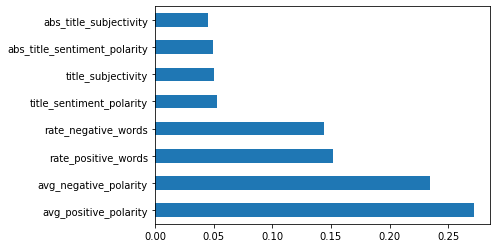

In [30]:
pd.Series(rf_model.feature_importances_, index = X.columns).nlargest(20).plot(kind = 'barh')

In [31]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test_scaled)

In [32]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
importances

array([0.15178761, 0.14448649, 0.27183921, 0.23458206, 0.0500117 ,
       0.0527089 , 0.04529652, 0.04928751])

In [33]:
# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.2718392072807326, 'avg_positive_polarity'),
 (0.23458206047193533, 'avg_negative_polarity'),
 (0.1517876093497667, 'rate_positive_words'),
 (0.1444864866750205, 'rate_negative_words'),
 (0.052708901911411817, 'title_sentiment_polarity'),
 (0.05001170127231644, 'title_subjectivity'),
 (0.049287510706352795, 'abs_title_sentiment_polarity'),
 (0.045296522332463895, 'abs_title_subjectivity')]

In [34]:
# classification metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))

[[7012  423]
 [2230  246]]


In [35]:
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

       False       0.76      0.94      0.84      7435
        True       0.37      0.10      0.16      2476

    accuracy                           0.73      9911
   macro avg       0.56      0.52      0.50      9911
weighted avg       0.66      0.73      0.67      9911



In [36]:
print(accuracy_score(y_test, predictions))

0.7323176268792251
